/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step

🔹 MAE (LSTM multivariado, escala real): 170,459.07 unidades
🔸 MAPE: 20.78%
🔸 BIAS: -13.81%


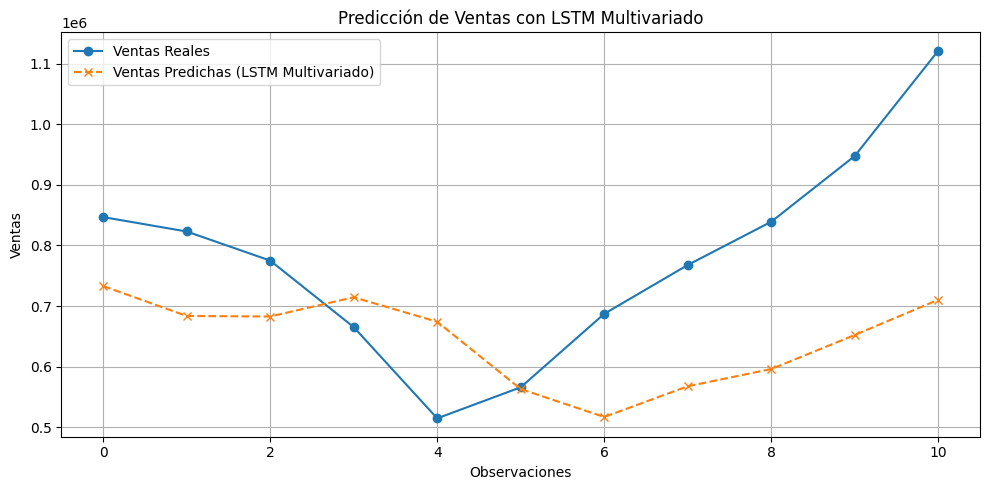

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Cargar datos
df = pd.read_csv("datos_ventas_inf.csv")
df["fecha"] = pd.to_datetime(df["fecha"], format="%Y-%m")
df = df.sort_values("fecha")

# Seleccionar variables
datos = df[["venta", "inflacion", "emae"]].values

# Escalar todas las variables
scaler = MinMaxScaler()
datos_scaled = scaler.fit_transform(datos)

# Crear secuencias multivariadas
def crear_secuencias_multivariadas(data, ventana=3):
    X, y = [], []
    for i in range(ventana, len(data)):
        X.append(data[i-ventana:i])
        y.append(data[i, 0])  # Solo queremos predecir la venta
    return np.array(X), np.array(y)

ventana = 3
X, y = crear_secuencias_multivariadas(datos_scaled, ventana)

# Dividir en entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Crear modelo LSTM multivariado
modelo_lstm_mv = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
modelo_lstm_mv.compile(optimizer='adam', loss='mse')

# Entrenamiento
modelo_lstm_mv.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.2, verbose=0)

# Predicciones
y_pred_scaled = modelo_lstm_mv.predict(X_test)

# Reescalar a valores reales de ventas
ventas_originales = df["venta"].values.reshape(-1, 1)
scaler_venta = MinMaxScaler()
scaler_venta.fit(ventas_originales[:split + ventana])

y_pred_real = scaler_venta.inverse_transform(y_pred_scaled)
y_real_real = scaler_venta.inverse_transform(y_test.reshape(-1, 1))

# Calcular métricas
mae_real = mean_absolute_error(y_real_real, y_pred_real)

# Asegurarse de que estén en 1D
y_real = y_real_real.flatten()
y_pred = y_pred_real.flatten()

# Evitar división por cero para MAPE
non_zero = y_real != 0
mape = np.mean(np.abs((y_real[non_zero] - y_pred[non_zero]) / y_real[non_zero])) * 100
bias = np.mean((y_pred - y_real) / y_real) * 100

# Mostrar resultados
print(f"\n🔹 MAE (LSTM multivariado, escala real): {mae_real:,.2f} unidades")
print(f"🔸 MAPE: {mape:.2f}%")
print(f"🔸 BIAS: {bias:.2f}%")

# Gráfico
plt.figure(figsize=(10, 5))
plt.plot(y_real, label="Ventas Reales", marker="o")
plt.plot(y_pred, label="Ventas Predichas (LSTM Multivariado)", linestyle="--", marker="x")
plt.title("Predicción de Ventas con LSTM Multivariado")
plt.xlabel("Observaciones")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
